In [496]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Ellipse
from matplotlib import gridspec
import scienceplots
import warnings

import ppxf.ppxf_util as util

from astropy.utils.exceptions import AstropyWarning
import astropy.units as u
from astropy import constants
from astropy.table import Table,QTable
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.visualization.mpl_normalize import simple_norm

from astropy.cosmology import Planck18
from astropy.modeling import models, fitting,polynomial
import astropy.modeling as modeling
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

#from photutils.aperture import EllipticalAperture, SkyEllipticalAperture
#from photutils.psf import PSFPhotometry,FittableImageModel,IterativePSFPhotometry
#from photutils.detection import DAOStarFinder
#from photutils.background import LocalBackground, MMMBackground

import os, sys, glob, pdb, re
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
sys.path.append('/disk/bifrost/yuanze/software/GalfitS-v0.9/src')
from galfits import gsutils, images as IM
from importlib import reload
reload(IM)
reload(gsutils)
import run_cubetools_v1 as ctools
from reproject import reproject_interp
from regions import Regions

from dust_extinction.parameter_averages import G23
from dustmaps.sfd import SFDQuery


ext_model = G23(Rv=3.1)
sfd = SFDQuery()

In [499]:
def write_fits(image, ra, dec, outputname, header = None,cutimg=None, addpixsc = False):
        '''
        Write the cut image to a FITS file.
        In order [cut_image, cut_mask_image, cut_sigma_image]
        '''
        if header is None:
            header=image.data.header
        hdu_temp = fits.PrimaryHDU(np.float32(image), header=header)
        hdu_temp.header['CRVAL1'] = ra
        hdu_temp.header['CRVAL2'] = dec
        hdu_temp.header['EXPTIME'] = 1
        hdu_temp.header['CRPIX1'] = cutimg.sources_skycord_cut[0]
        hdu_temp.header['CRPIX2'] = cutimg.sources_skycord_cut[1]
        if addpixsc:
            hdu_temp.header['CDELT1'] = cutimg.pixel_scales[0].value/3600
            hdu_temp.header['CDELT2'] = cutimg.pixel_scales[1].value/3600
#        hdu_temp2 = fits.ImageHDU(np.float32(self.cut_mask_image))
#        hdu_temp3 = fits.ImageHDU(np.float32(self.cut_sigma_image))
        hdul = fits.HDUList([hdu_temp])
        hdul.writeto(outputname, overwrite=True)
        return
    
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})

In [689]:
os.listdir(datapath)

['Q1549_F606W_075_drc_sci.fits',
 'Q1549_F125W_075_drz_sci.fits',
 'Q1549_F475w_sci_wcs.fits',
 'q1549_wfc3_f160w_all.fits',
 'f125w_v6_NewWCS_drz_sci.phot.fits',
 'f160w_075.fits',
 'Q1549_hst_f160w_wfc3_epsf.fits',
 'Q1549_hst_f606w_acs_epsf.fits',
 'hst_f606w_epsf.fits',
 '.ipynb_checkpoints',
 'hst_f475w_epsf.fits',
 'q1549_f160w_core.fits',
 'hst_f160w_epsf.fits',
 'f125w_tot.fits',
 'f606w_tot.fits']

Found: ['q1549_wfc3_f160w_all.fits', 'Q1549_hst_f160w_wfc3_epsf.fits', 'q1549_f160w_core.fits']
reading: /disk/bifrost/yuanze/KBSS/Q1549/hst/q1549_wfc3_f160w_all.fits
INFO: using the unit cR passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


Unit is cR, no conversion required
conversion factor from erg/s/cm**2/AA to ADU: 5.187905415353564e+19
using EXPTIME: 30998.851497


0.004868834


original table have length 1045, become 0 after Gaia cross match
total sources:  1045
sources above thereshold flux : 215
sources above thereshold axis ratio : 43
PSF FWHM: 1.25, median: 7.14, std: 1.43
sources within threshould fwhm : 25
sources isolate (or look like the input PSF): 25
sources remove central bad : 25


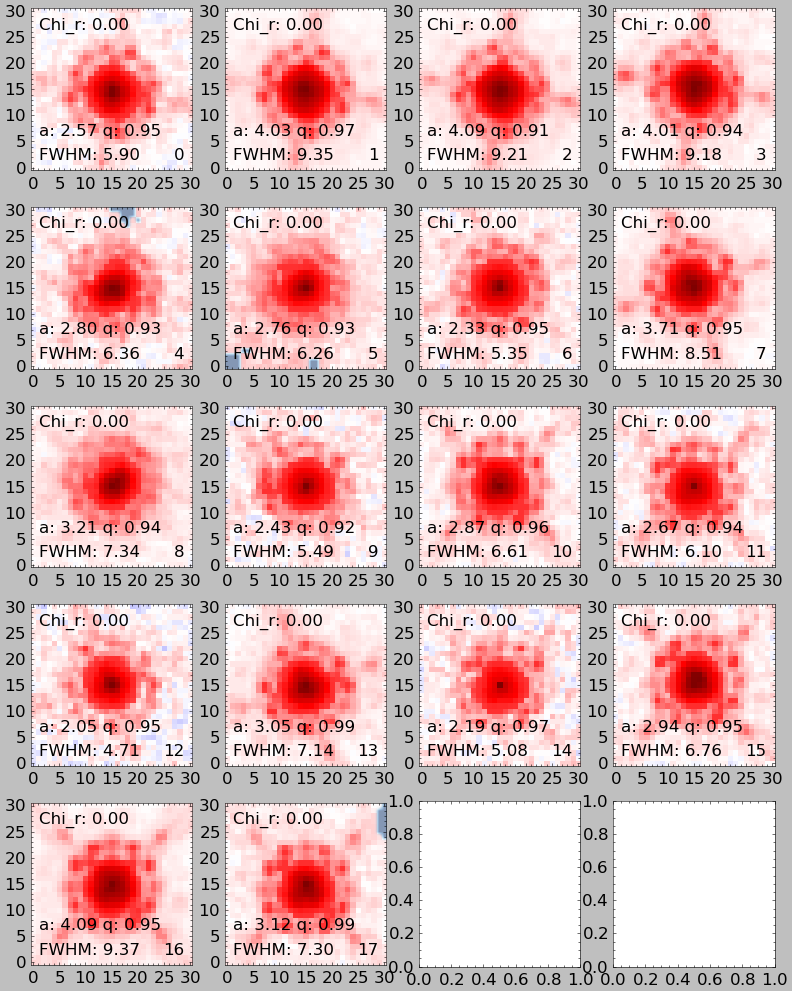

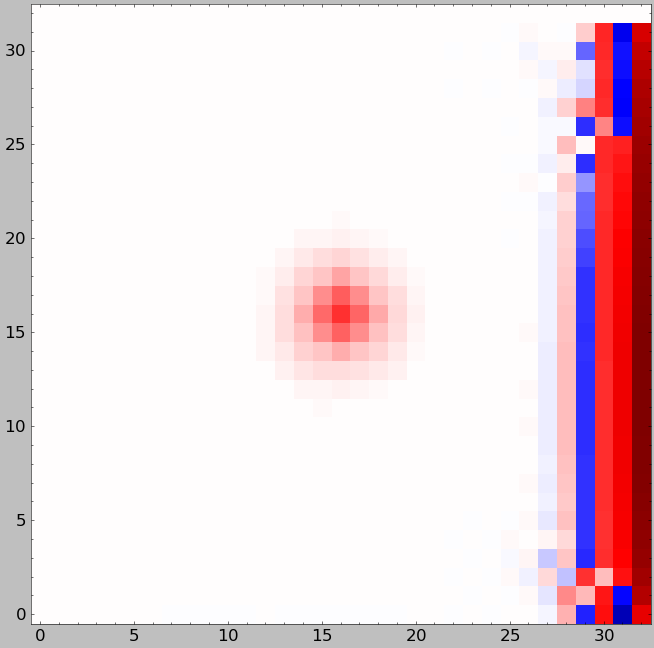

In [1116]:
importlib.reload(IM)

KBSSpath="/disk/bifrost/yuanze/KBSS"
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")
filters = ["table['KCWI'] == 'yes'","table['Field']=='Q1549'","table['Name']=='MD17'","table['Name']!='Lab5'","table['Name']!='FSzP1170'"]
dtype="KBSS"
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"),channel="blue")


datatype="hst" #hst or spitzer or jwst or lris
inst="wfc3"
filter_name="f160w"
skysub=False
write_cutimg=False
generate_PSF=True

ZPs={"Q0100":{"Rs_lris":34.24,"G_lris":34.37,"Un_lris":32.71,"mosfire_Ks":27.63,"mosfire_H":28.19,"mosfire_J":28.66}}
lambda_piv={"f277w":27762.1,"f150w":15008.98} ## pivotal wavelength in AA
for ind,sentry in enumerate(qsotab):
    field=sentry["Field"]
    sname=sentry["Name"]
    ra = sentry["RA"]
    dec = sentry["Decl"]
    subdapath=all_directories[ind].replace("kcwib",datatype)
    if not os.path.exists(subdapath):
        os.makedirs(subdapath)
    sc = SkyCoord(ra=ra,dec=dec,unit="deg")
    matches=[]
    errimg=None
    if datatype== "mosfire":
        pattern = re.compile(r"^{}{}.*mosfire.fits$".format(field,filter_name), re.IGNORECASE)
        datapath=KBSSpath+"/"+field+"/"+datatype
        ewave=gsutils.effective_wave[f"mosfire_{filter_name}"]
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        img = IM.image(datapath+"/"+matches[0],hdu=0,unit="electron")
        outname=subdapath+"/imaging/"+matches[0].replace(".fits",f"_{sname}")
        hdu = fits.open(datapath+"/"+matches[0])
        header = hdu[0].header
        data_org = hdu[0].data
        #flambda*factor = image unit
        print("conversion factor from erg/s/cm**2/AA to ADU:",1/image_to_flambda(ZPs[field]["mosfire_"+filter_name],gsutils.effective_wave["mosfire_"+filter_name]))
    if datatype== "lris":
        pattern = re.compile(r"^{}{}.fits$".format(field,filter_name), re.IGNORECASE)
        datapath=KBSSpath+"/"+field+"/"+datatype
        ewave=gsutils.effective_wave[f"{filter_name}_lris"]
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        img = IM.image(datapath+"/"+matches[0],hdu=0,unit="electron")
        outname=subdapath+"/imaging/"+matches[0].replace(".fits",f"_{sname}")
        hdu = fits.open(datapath+"/"+matches[0])
        header = hdu[0].header
        data_org = hdu[0].data
        #flambda*factor = image unit
        print("conversion factor from erg/s/cm**2/AA to ADU:",1/image_to_flambda(ZPs[field][filter_name+"_lris"],gsutils.effective_wave[filter_name+"_lris"]))
    elif datatype == "hst":
        #pattern = re.compile(r"^{}.*.NewWCS.*.fits$".format(filter_name), re.IGNORECASE)
        pattern = re.compile(r"^{}.*.{}.*.fits$".format(field,filter_name), re.IGNORECASE)
        #pattern = re.compile(r"^{}.*tot.fits$".format(filter_name), re.IGNORECASE)
        #pattern = re.compile(r"^u5800501b.*.2.fits$", re.IGNORECASE)
        datapath=KBSSpath+"/"+field+"/"+datatype
        ewave=gsutils.effective_wave[f"{inst}_{filter_name}"]
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        selected_match=matches[0]
        print("reading:",datapath+"/"+selected_match)
        hdu = fits.open(datapath+"/"+selected_match)
        header = hdu[0].header
        mexp=header["EXPTIME"]
        data_org = hdu[0].data
        img = IM.image(datapath+"/"+selected_match,hdu=0,unit="cR")
        if ("D001OUUN" in header.keys()) and header["D001OUUN"] == "cps":
            print("Unit is cR, no conversion required")
        else:
            print("converting to cR ... ")
            img.data.data=img.data.data/mexp
        outname=subdapath+"/"+selected_match.replace(".fits",f"_{sname}")
        
        print("conversion factor from erg/s/cm**2/AA to ADU:",1/header["PHOTFLAM"])
    elif datatype == "jwst":
        pattern = re.compile(r".*.{}.*_sci.fits$".format(filter_name), re.IGNORECASE)
        datapath=KBSSpath+"/"+field+"/"+datatype
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        #fprefix = datapath.split("/")[-1]
        #fname = datapath+"/"+fprefix+"_drc.fits"
        #outname = datapath+"/"+fprefix
        #hdu = fits.open(outname+'_cutimg.fits')
        #cfac=1.
        img = IM.image(datapath+"/"+matches[0],hdu=0,unit="MJy/sr")
        pixscale=img.data.wcs.pixel_scale_matrix[1,1]*3600
        Opix=(pixscale/(1/np.pi*180*3600))**2 ## steradian per pixel
        u2flam=u.MJy.to(u.erg/u.s/u.cm**2/u.Hz)*constants.c.to(u.AA/u.s).value/lambda_piv[filter_name]**2*Opix
        print("conversion factor from erg/s/cm**2/AA to MJy/sr:",1/u2flam)
        outname=subdapath+"/"+matches[0].replace(".mosaic.fits",f"_{sname}")
        hdu = fits.open(datapath+"/"+matches[0])
        header = hdu[0].header
        data_org = hdu[0].data
        #errimg = fits.open(datapath+"/"+matches[0].replace(".mosaic.fits",".mosaic.wt.fits"))[0].data
    elif datatype == "spitzer":
        if "ch" in filter_name:
            tel="irac"
            postfix=".*.mosaic"
        else:
            tel="mips"
            postfix=""
        datapath = KBSSpath+f"/kbss_{tel}/{field}"
        matches=[]
        if field=="GWS":
            pattern = re.compile(r'^CDS_EGS.*.{}.*{}.fits$'.format(filter_name,"ima_v24lin"), re.IGNORECASE)
        elif field=="LyC22":
            pattern = re.compile(r'^ssa22.*.{}.*{}.fits$'.format(filter_name,postfix), re.IGNORECASE)
        else:
            pattern = re.compile(r'^{}.*.{}{}.fits$'.format(field,filter_name,postfix), re.IGNORECASE)
        
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        if field=="GWS":
            covhdu = fits.open(datapath+"/"+matches[0].replace("ima","tim"))
        else:
            covhdu = fits.open(datapath+"/"+matches[0].replace("mosaic","cov"))
        img = IM.image(datapath+"/"+matches[0],hdu=0,unit="MJy/sr")
        pixscale=img.data.wcs.pixel_scale_matrix[1,1]*3600
        Opix=(pixscale/(1/np.pi*180*3600))**2 ## steradian per pixel
        u2flam=u.MJy.to(u.erg/u.s/u.cm**2/u.Hz)*constants.c.to(u.AA/u.s).value/gsutils.effective_wave[filter_name]**2*Opix
        print("conversion factor from erg/s/cm**2/AA to MJy/sr:",1/u2flam)
        outname=subdapath+"/"+matches[0].replace("_mosaic.fits","")
        #pix_scale=hdu[0].header["PXSCAL2"]
        #print("pix_scale=",pix_scale)
        #cfac=2.350443e-5*pix_scale**2/1e23 # MJy/Sr to erg/s/cm^2/Hz/pixel (Fnu)
        #cfacJy=2.350443e-5*pix_scale**2
    #conver={"ch2":0.1382,"ch4":0.2026}
    #dataname="q1549_irac_"+subtype+"_mosaic.fits"
    #dataname="Q1549_F606W_075_drc_sci.fits"
    header = img.data.header
    if datatype=="spitzer":
        mexp=np.nanmedian(covhdu[0].data[cp[2]:cp[3],cp[0]:cp[1]])
        print("using median exposure time in coverage image:",mexp)
    elif datatype=="mosfire":
        mexp=2800
    elif errimg is None:
        try:
            mexp=header["EXPTIME"]
        except:
            print("EXPTIME does not exist in header")
            mexp=1e4
        print("using EXPTIME:",mexp)

    if errimg is not None:
        sigimg=errimg
    else:#m
        sigimg = np.sqrt(img.data.data**2*0.1**2+img.cal_sigma_image(mexp, gain = 1.)**2)
    
    if write_cutimg:
        imagecut=True

        cutsize_arcsec=5 #arcsec
        imcut, cp = img.img_cut(ra,dec,cutsize_arcsec)
        if skysub:
            print("conducting sky subtraction...")
            sdmask=data_org<1e-5
            maskplus = img.sky_subtraction(psfFWHM=0.15,npixels=6,sdmask=sdmask,max_grow_size=30,addgrow=1, polyfit=True, usemedian=False,filepath=outname+"_ssimg.fits")
            sky_mean, sky_median, sky_std = sigma_clipped_stats(imcut, sigma=3)
            immin = 1 * sky_std
            immax = 5 * sky_std

            # Visualize the original image, sky-subtracted image, and the subtracted sky
            fig = plt.figure(figsize=(18,6))
            ax1 = fig.add_subplot(131)
            ax1.imshow(gsutils.normimg(data_org, immin, immax, sky=sky_median, frac=0.6),
                       cmap='seismic', origin='lower', vmin=-1, vmax=1, interpolation='nearest')
            ax2 = fig.add_subplot(132)
            ax2.imshow(gsutils.normimg(data_org - img.data.data, immin, immax, sky=sky_median, frac=0.6),
                       cmap='seismic', origin='lower', vmin=-1, vmax=1, interpolation='nearest')
            ax3 = fig.add_subplot(133)
            ax3.imshow(gsutils.normimg(img.data.data, immin, immax, frac=0.6),
                       cmap='seismic', origin='lower', vmin=-1, vmax=1, interpolation='nearest')
            plt.show()


        
        img.cut_sigma_image = sigimg[cp[2]:cp[3],cp[0]:cp[1]]
        img.cut_mask_image = np.zeros_like(img.cut_sigma_image)
        img.cut_mask_image = img.generate_cutmask(0.1,nsigma=3,deblend=True,addgrow=1,nlevels=5,source_dia=50,contrast=0.001)
        
        # Perform sky subtraction with a 3rd order polynomial

       # wcsall=WCS(hdu[0].header)
        sc = SkyCoord(ra=ra, dec=dec, unit='deg',frame='icrs', equinox='J2000')
        # Calculate the size of the cutout in pixels
        #pix_scale = wcsall.pixel_scale_matrix[1, 1] * 3600  # scale in arcsec/pixel
        #cutsize_pixels = cutsize_arcsec / pix_scale

        sky_mean, sky_median, sky_std = sigma_clipped_stats(img.cut_image, sigma=3, maxiters=5)
        norm = simple_norm([sky_std, 10*sky_std], 'linear', percent=100)
        fig = plt.figure(dpi=300)
        plt.imshow(img.cut_image-sky_median,origin='lower',cmap='gray_r',norm=norm)
        #plt.imshow(img.cut_sigma_image,origin='lower',cmap='gray_r')
        plt.imshow(img.cut_mask_image,origin='lower',cmap='Blues',alpha=img.cut_mask_image.astype(float)*0.5)
        ebv=sfd(sc)
        Av = ebv*3.1
        if datatype !="hst":
            ewave=gsutils.effective_wave[filter_name]
        Alam = ext_model(ewave*u.AA)*Av
        print("Saving result as:",outname)
        print(f"MW extinction corrected with Av={Av},EBV={ebv}, at observed frame {ewave}")
        img.write_imcut(ra, dec, outname+"_cut.fits", header=header,Alamda=Alam)
        #write_fits(sigimg[cp[2]:cp[3],cp[0]:cp[1]],ra,dec,outname+'_cutsigma.fits',cutimg=img,header=header)
        #writing mask image
        #write_fits(img.cut_mask_image,ra,dec,outname+'_cutmask.fits',cutimg=img,header=header)
        #writing cut image
        #write_fits(img.cut_image,ra,dec,outname+'_cutimg.fits',cutimg=img,header=header)
#0,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23
    if generate_PSF:
        epsf = img.generate_PSFs(0.1,data=None, nsigma=3,sigmaimg=sigimg, fluxthreshould =0.1, isolate = 0.1,npixels=50,qt = 0.9,a_sky=5,a_TV=1e4,# sigfwhm = 1,medianfwhm=2, a_TV=1e6.,
                          plot=True,size = 31,oversampling=1,photutils_method=True, filepaths=datapath+f"/{datatype}_{filter_name}_epsf.fits",\
                                 droppsf=[5,6,9,13,20,21,23],crossmatch=True, notfit=False,makestackpsf=False)

In [702]:
from photutils.aperture import EllipticalAperture, SkyEllipticalAperture
from photutils.psf import PSFPhotometry,FittableImageModel,IterativePSFPhotometry
from photutils.detection import DAOStarFinder
from photutils.background import LocalBackground, MMMBackground

In [777]:
def image_to_flambda(zp_ab, lam_pivot):
    """
    Convert an image in 'img units' (assumed to match the ZP definition, typically counts/s)
    to f_lambda [erg/s/cm^2/Angstrom], using an AB zeropoint and a pivot wavelength.

    Parameters
    ----------
    img : array-like
        Image values S (e.g., counts/s).
    zp_ab : float
        AB magnitude zeropoint such that m_AB = -2.5 log10(S) + zp_ab.
    lam_pivot : float or Quantity
        Pivot (or effective) wavelength. If float, assumed Angstrom.

    Returns
    -------
    flambda : Quantity
        Flux density per wavelength [erg/s/cm^2/Angstrom].
    """
    from astropy.constants import c
    lam = lam_pivot * u.AA if not hasattr(lam_pivot, "unit") else lam_pivot.to(u.AA)

    # factor to convert S -> f_nu in cgs
    fnu_per_S = 10**(-0.4 * (zp_ab + 48.6)) * (u.erg / u.s / u.cm**2 / u.Hz)

    #fnu = np.asarray(img) * fnu_per_S
    #flambda = (fnu * c / lam**2).to(u.erg / u.s / u.cm**2 / u.AA)
    factor = (fnu_per_S*c / lam**2).to(u.erg / u.s / u.cm**2 / u.AA)
    return factor
#factor * image = flambda

In [1103]:
psfim = fits.open(datapath+f"/{datatype}_{filter_name}_epsf.fits")[0].data
psf_model = FittableImageModel(psfim)

bkgstat = MMMBackground()
localbkg_estimator = LocalBackground(5, 15, bkgstat)

fit_shape = [5,5]
finder = DAOStarFinder(0.05, 4.0)#, finder=finder
#Do iterative PSF photometry


init_params = QTable()

xini=16.85
yini=16.69
#for ind,RA in enumerate([ra]):
    #sc = SkyCoord(ra=ra, dec=dec, unit='deg',frame="icrs", equinox='J2000')
    #s_coord=[len(img.cut_image)/2,len(img.cut_image)/2]#img.data.wcs.world_to_pixel(sc)
    #xini.append(s_coord[0].flatten()[0])
    #yini.append(s_coord[1].flatten()[0])
fix_pos=False

if fix_pos:
    init_params['x'] = [xini]#xini
    init_params['y'] = [yini]
    psf_model.x_0.fixed = True
    psf_model.y_0.fixed = True
else:
    init_params['x'] = [len(img.cut_image)/2]#xini
    init_params['y'] = [len(img.cut_image)/2]# yini
    #xy_bounds=None
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,localbkg_estimator=localbkg_estimator,
                        aperture_radius=2,fitter_maxiters=10000)
factor = 10**(0.4*Alam)
phot = psfphot(img.cut_image*factor, error=img.cut_sigma_image*factor,mask=img.cut_mask_image.astype(bool),init_params=init_params)



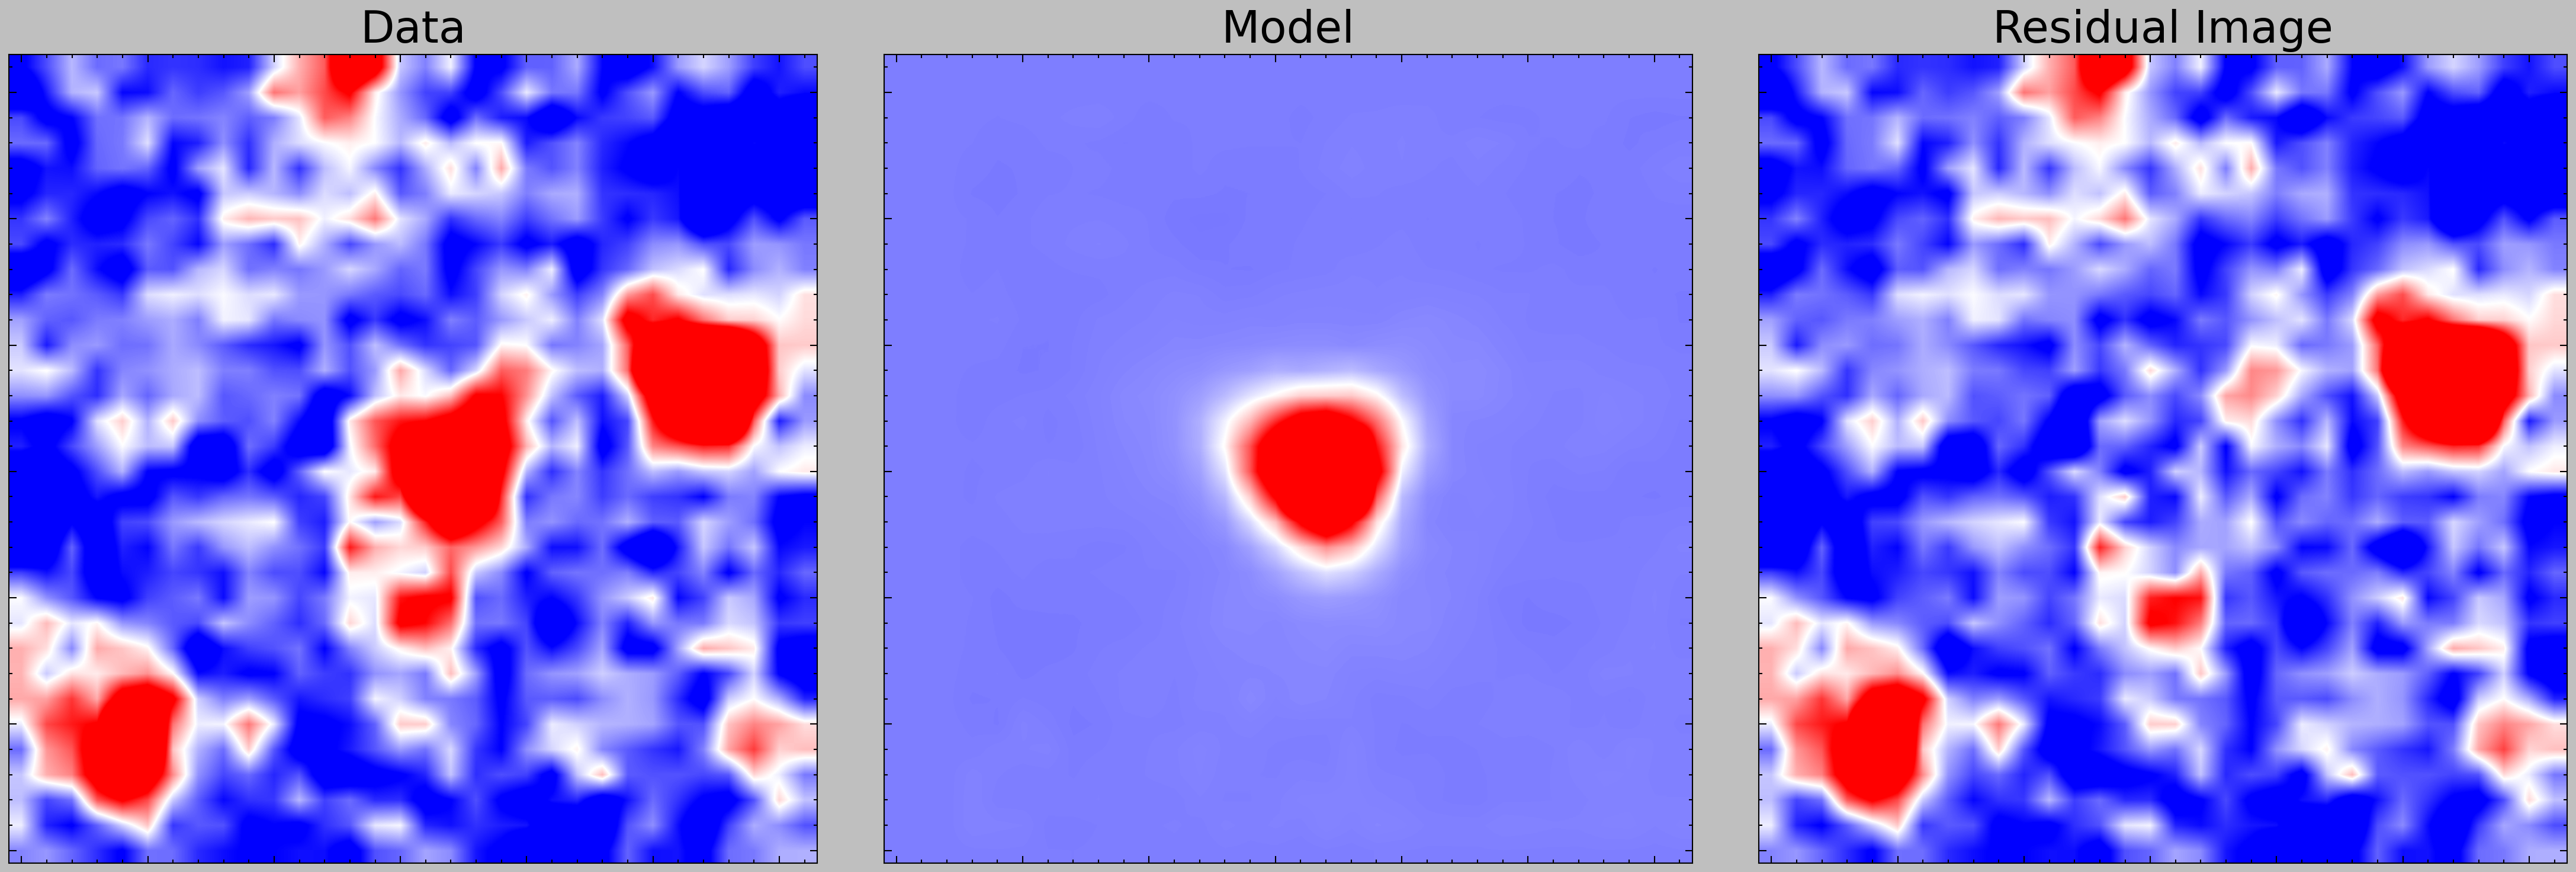

In [1104]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})


resid = psfphot.make_residual_image(img.cut_image, (49, 49))
resid -= np.mean(phot["local_bkg"])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),dpi=300,sharey=True,sharex=True)
sky_mean, sky_median, sky_std = sigma_clipped_stats(img.cut_image, sigma=3.0, maxiters=5)
cmap='bwr'
norm = simple_norm([-1*sky_std, 3*sky_std], 'linear', percent=99)
ax[0].imshow(img.cut_image-phot["local_bkg"].value, origin='lower',cmap=cmap, norm=norm)

ax[1].imshow(img.cut_image- resid-phot["local_bkg"].value, origin='lower',cmap=cmap, norm=norm)
im=ax[2].imshow(resid,cmap=cmap, origin='lower', norm=norm)
#
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')

#plt.colorbar(im)
x0, y0 = 30, 30
arrow_length = 15/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
#sky_coords = wcsinfo.pixel_to_world(x0, y0)
#ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
#north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
#east_end = wcsinfo.world_to_pixel_values(ra - arrow_length, dec)


# Calculate the direction vectors for the arrows
#north_vector = [north_end[0] - x0, north_end[1] - y0]
#east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
#ax[0].quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
#ax[0].text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='w', ha='center', va='bottom')

# Plot the East arrow
#ax[0].quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
#ax[0].text(x0 + east_vector[0]/2+5, y0 + east_vector[1]/2, 'E', color='w', ha='center', va='top')
#ax[0].text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")

#for ent in phot["x_fit","y_fit"]:
    #ax[0].plot(ent["x_fit"], ent["y_fit"],"+",c="r",ms=10,lw=0.1)
for axx in ax:
    axx.set_xticklabels([])
    axx.set_yticklabels([])
fig.savefig(subdapath+"/{}_{}_{}.pdf".format(datatype,inst,filter_name))

plt.tight_layout()



In [1105]:
phot["flux_fit"]*u.MJy.to(u.uJy)*Opix,phot["flux_err"]*u.MJy.to(u.uJy)*Opix

(<Column name='flux_fit' dtype='float64' length=1>
 0.8289795783739055,
 <Column name='flux_err' dtype='float64' length=1>
 0.6482216366849746)

In [1106]:
16.4-2.5*np.log10(phot["flux_fit"]*u.MJy.to(u.mJy)*Opix)

24.10364042003193


In [1107]:
phot["flux_err"]/phot["flux_fit"]*1.0857

0.8489644972067631


In [992]:
phot

id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,group_size,qfit,cfit,flags
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64
1,1,1.4674962265738127,16.0,16.0,3.3519342675415116,15.482379337730592,14.711732876198644,2.6049057432041005,1.4321098919770971,1.5332521225535276,1.6002829493779196,25,1,0.29096087361927786,0.01872861876912701,0


In [435]:
resid[25,7]

np.float64(0.0010926105290915596)